In [1]:
import os
import numpy as np
import csv
import shutil
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from train_dataset import img_segmention,img_patch


# Config

In [2]:
source_folder = "dataset/mini_testdatensatz"
im_size = [192,192]
min_pix = 300
max_pix = 450

# Clear Dataset I

In [3]:
# Path to the folder containing image files
source_folder_train = source_folder + "/train"

mask_size = [[],[]]
global_mask = np.zeros((im_size[0],im_size[1]))

# Iterate through all files in the folder
for filename in tqdm(os.listdir(source_folder_train)):
    # Check if the file is an image file
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
        # Process the image
        image_path = os.path.join(source_folder_train, filename)
        img = Image.open(image_path) # Open the image file
        img_resized = img_patch(img, im_size) # Resize the image

        # Perform image segmentation on the resized image
        try:
            _,mask,_ = img_segmention(img_resized)
            num_ones = np.count_nonzero(mask)
            mask_size[0].append(num_ones)
            mask_size[1].append(filename)
            global_mask = np.add(global_mask,mask) # Add the mask to the global mask
        except:
            # If an error occurs during segmentation, delete the image file
            os.remove(image_path)
            print("The image", filename, "caused an error during img_segmention and has been deleted")

  0%|          | 0/165 [00:00<?, ?it/s]/home/scco0002/F&E_DeepLearning_VS/deepl_env/lib/python3.8/site-packages/skimage/util/dtype.py:541: UserWarning: Downcasting int64 to uint8 without scaling because max value 2 fits in uint8
  return _convert(image, np.uint8, force_copy)
/home/scco0002/F&E_DeepLearning_VS/deepl_env/lib/python3.8/site-packages/skimage/util/dtype.py:541: UserWarning: Downcasting int64 to uint8 without scaling because max value 3 fits in uint8
  return _convert(image, np.uint8, force_copy)
100%|██████████| 165/165 [00:06<00:00, 23.69it/s]


# Sort the list mask_size

In [4]:
# Create a list of tuples containing (num_ones, filename) pairs
pairs = list(zip(mask_size[0], mask_size[1]))

# Sort the list of tuples based on the first element (num_ones)
sorted_pairs = sorted(pairs, key=lambda x: x[0])

# Extract the sorted lists of num_ones and filenames using list comprehensions
sorted_mask_size = [pair[0] for pair in sorted_pairs]
sorted_filenames = [pair[1] for pair in sorted_pairs]

mask_size_with_filename = [sorted_mask_size, sorted_filenames]

# Global Mask --> average of all masks

In [5]:
max_index = np.argmax(global_mask)
# use np.unravel_index to find the row and column indices of the maximum value
max_row, max_col = np.unravel_index(max_index, global_mask.shape)
print("The maximum value of the global mask is", global_mask[max_row, max_col], "at row", max_row, "and column", max_col)

The maximum value of the global mask is 100.0 at row 116 and column 139


In [6]:
global_mask_adjust = (global_mask - global_mask.min()) * (255 / (global_mask.max() - global_mask.min()))
# Save the global mask as an image
global_mask_img = Image.fromarray(global_mask_adjust.astype(np.uint8))
global_mask_img.save("analyse_dataset/global_mask.png")


# Write in csv

In [7]:
with open('analyse_dataset/mask_size.csv', mode='w') as file:
    writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['Mask Size', 'Filename'])
    for i in range(len(mask_size_with_filename[0])):
        writer.writerow([mask_size_with_filename[0][i], mask_size_with_filename[1][i]])

# Mean and Standard Deviation before Clear II

In [8]:
pixel_counts = []
with open('analyse_dataset/mask_size.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader) 
    for row in reader:
        pixel_counts.append(int(row[0]))

mean = np.mean(pixel_counts)
std = np.std(pixel_counts)

print("Mean:", mean)
print("Standard Deviation:", std)

Mean: 328.969696969697
Standard Deviation: 62.36154839394217


# Histogramm before Clear II

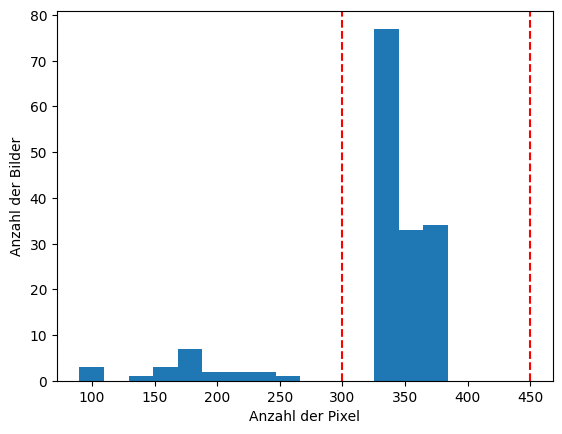

In [9]:
# 1. Lesen Sie die CSV-Datei ein und speichern Sie die Anzahl der Pixel und den Dateinamen in separaten Listen.
pixel_counts = []
filenames = []
with open('analyse_dataset/mask_size.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader) 
    for row in reader:
        pixel_counts.append(int(row[0]))
        filenames.append(row[1])


# 2. Erstellen Sie eine Liste, die alle einzigartigen Anzahlen von Pixeln enthält.
unique_counts = list(set(pixel_counts))

# 3. Verwenden Sie eine Schleife, um durch jede einzigartige Anzahl von Pixeln in der Liste zu iterieren.
histogram_data = []
for count in unique_counts:
    # 4. Zählen Sie die Anzahl der Bilder, die die aktuelle Anzahl von Pixeln aufweisen.
    num_images = 0
    for i in range(len(pixel_counts)):
        if pixel_counts[i] == count:
            num_images += 1
    # 5. Fügen Sie die Anzahl der Bilder mit der aktuellen Anzahl von Pixeln zu einer neuen Liste hinzu.
    histogram_data.append(num_images)

# 6. Erstellen Sie das Histogramm der Anzahl der Bilder mit verschiedenen Pixelanzahlen.
# Erstellen des Histogramms wie zuvor
unique_counts = list(set(pixel_counts))
histogram_data = [pixel_counts.count(count) for count in unique_counts]
plt.hist(pixel_counts, bins=len(unique_counts))
plt.axvline(x=min_pix, color='r', linestyle='--')
plt.axvline(x=max_pix, color='r', linestyle='--')
plt.xlabel('Anzahl der Pixel')
plt.ylabel('Anzahl der Bilder')
plt.show()

In [10]:
# Öffnen der CSV-Datei und Lesen der Daten
pixel_counts = []

with open('analyse_dataset/mask_size.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)  # Überspringen der Kopfzeile
    pixel_counts = [int(row[0]) for row in reader]

# Initialisierung der Zählvariablen
below = 0
above = 0

# Schleife durch die Liste und Zählen der Werte
for count in pixel_counts:
    if count < min_pix:
        below += 1
    elif count > max_pix:
        above += 1

# Ausgabe der Ergebnisse
print("Anzahl der Werte mit weniger als",str(min_pix),"Pixel:", below)
print("Anzahl der Werte mit weniger als",str(max_pix),"Pixel:", above)

Anzahl der Werte mit weniger als 300 Pixel: 21
Anzahl der Werte mit weniger als 450 Pixel: 0


# Copy Dataset

In [11]:
destination_folder = source_folder + "_cleared"

if os.path.exists(destination_folder):
    shutil.rmtree(destination_folder)

shutil.copytree(source_folder, destination_folder)
    

'dataset/mini_testdatensatz_cleared'

# Clear II (only Copy Dataset is cleared)

In [12]:
pixel_counts = []
filenames = []

with open('analyse_dataset/mask_size.csv', 'r') as inp, open('analyse_dataset/mask_size_cleared.csv', 'w') as out:
    writer = csv.writer(out)
    reader = csv.reader(inp)
    next(reader) 
    for row in reader:
        if int(row[0]) < min_pix:
            try:
                os.remove(os.path.join(destination_folder,"train",row[1]))
                print("The mask oft the image", str(row[1]), "was too small. The image has been deleted")
            except:
                print("The dataset has already been cleared")
        elif int(row[0]) > max_pix:
            try:
                os.remove(os.path.join(destination_folder,"train",row[1]))
                print("The mask oft the image", str(row[1]), "was too large. The image has been deleted")
            except:
                 print("The dataset has already been cleared")
        else:
            writer.writerow(row)


The mask oft the image picture_771.png was too small. The image has been deleted
The mask oft the image picture_767.png was too small. The image has been deleted
The mask oft the image picture_768.png was too small. The image has been deleted
The mask oft the image picture_765.png was too small. The image has been deleted
The mask oft the image picture_769.png was too small. The image has been deleted
The mask oft the image picture_776.png was too small. The image has been deleted
The mask oft the image picture_777.png was too small. The image has been deleted
The mask oft the image picture_782.png was too small. The image has been deleted
The mask oft the image picture_780.png was too small. The image has been deleted
The mask oft the image picture_785.png was too small. The image has been deleted
The mask oft the image picture_784.png was too small. The image has been deleted
The mask oft the image picture_774.png was too small. The image has been deleted
The mask oft the image pictu

# Mean and Standard Deviation after Clear II

In [13]:
pixel_counts = []
with open('analyse_dataset/mask_size_cleared.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader) 
    for row in reader:
        pixel_counts.append(int(row[0]))

mean = np.mean(pixel_counts)
std = np.std(pixel_counts)

print("Mean:", mean)
print("Standard Deviation:", std)

Mean: 351.4965034965035
Standard Deviation: 13.773326875849886


# Histogramm after Clear II

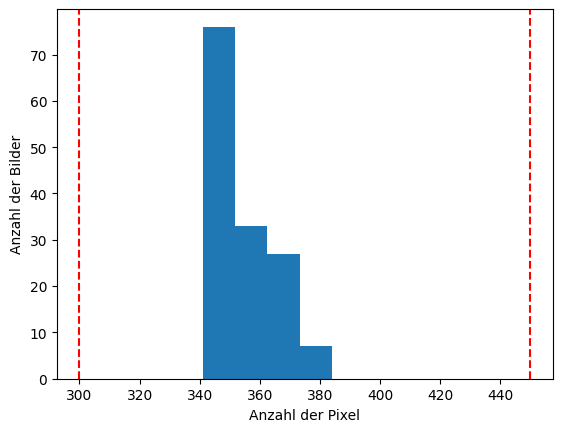

In [14]:
# 1. Lesen Sie die CSV-Datei ein und speichern Sie die Anzahl der Pixel und den Dateinamen in separaten Listen.
pixel_counts = []
filenames = []
with open('analyse_dataset/mask_size_cleared.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader) 
    for row in reader:
        pixel_counts.append(int(row[0]))
        filenames.append(row[1])


# 2. Erstellen Sie eine Liste, die alle einzigartigen Anzahlen von Pixeln enthält.
unique_counts = list(set(pixel_counts))

# 3. Verwenden Sie eine Schleife, um durch jede einzigartige Anzahl von Pixeln in der Liste zu iterieren.
histogram_data = []
for count in unique_counts:
    # 4. Zählen Sie die Anzahl der Bilder, die die aktuelle Anzahl von Pixeln aufweisen.
    num_images = 0
    for i in range(len(pixel_counts)):
        if pixel_counts[i] == count:
            num_images += 1
    # 5. Fügen Sie die Anzahl der Bilder mit der aktuellen Anzahl von Pixeln zu einer neuen Liste hinzu.
    histogram_data.append(num_images)

# 6. Erstellen Sie das Histogramm der Anzahl der Bilder mit verschiedenen Pixelanzahlen.
# Erstellen des Histogramms wie zuvor
unique_counts = list(set(pixel_counts))
histogram_data = [pixel_counts.count(count) for count in unique_counts]
plt.hist(pixel_counts, bins=len(unique_counts))
plt.axvline(x=min_pix, color='r', linestyle='--')
plt.axvline(x=max_pix, color='r', linestyle='--')
plt.xlabel('Anzahl der Pixel')
plt.ylabel('Anzahl der Bilder')
plt.show()

# Testmask --> only one mask to test images

In [16]:
path = 'dataset/mini_testdatensatz_cleared/train/picture_1.png'
img = Image.open(path) # Open the image file
im_size= [192,192]
img_resized = img_patch(img, im_size) # Resize the image

# Perform image segmentation on the resized image
_,mask,_ = img_segmention(img_resized)
mask[mask == 1] = 255


mask_img = Image.fromarray(mask.astype(np.uint8))
mask_img.save("analyse_dataset/test_mask_img.png")

img_resized_np = np.array(img_resized)
cut = np.zeros_like(img_resized_np)
cut[mask != 0] = img_resized_np[mask != 0]
cut_img = Image.fromarray(cut.astype(np.uint8))
cut_img.save("analyse_dataset/test_cut_img.png")
